![Biogeochemical Argo](https://biogeochemical-argo.org/images/logo@2x.png)

# Introduction to Argo Observations

---

## Overview

Argo floats are autonomous profiling instruments that sample the interior ocean by traveling with the ocean currents. They are part of the Argo program, an international collaborative effort to monitor the state of the ocean. The deployment of thousands of Argo floats has enabled new observation-based studies in previously undersampled regions (e.g. Wong et al. 2020, Swart et al. 2023). Some newer Argo floats, known as Biogeochemical-Argo (BGC-Argo) floats, have been further equipped with biologically relevant sensors for oxygen, nitrate, optical backscatter, and chlorophyll fluorescence (Claustre et al. 2020, Sarmiento et al. 2023, Roemmich et al. 2019). Argo floats provide critical data that enhances our understanding of the ocean and its influence on the global climate system. Through international collaboration and advanced technology, the Argo program plays a vital role in monitoring and studying the world's oceans. 


Here, we introduce Argo profiling floats, which are autonomous instruments that operate remotely and sample the ocean interior continuously. 
Our objectives:

1. What are Argo floats? 
2. How are the data formatted? 
3. How can we transform data to work with?
3. What are some ways of visualizing float data?
 
In the next notebook, [Accessing Argo Data](notebooks/argo-access.ipynb), we will explore different ways of downloading and retrieving float profiles. 


### Basic profiling scheme of an Argo float

Float Cycle Diagram, courtesy of UCSD (https://argo.ucsd.edu/how-do-floats-work/) 


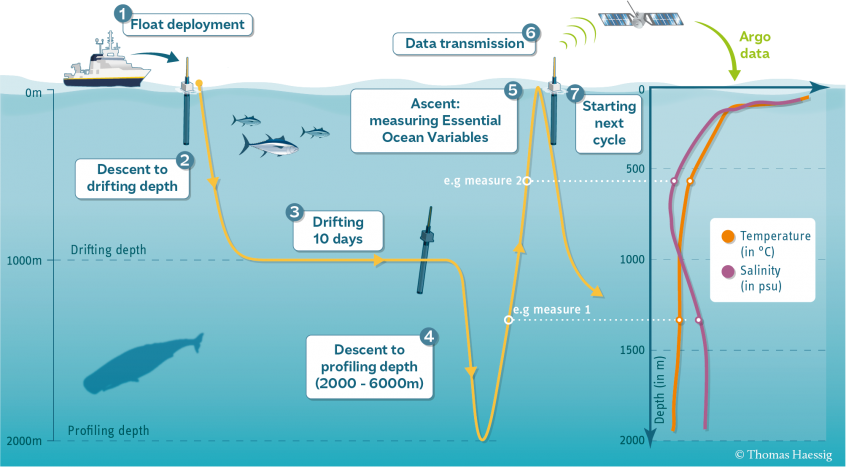

In [2]:
from IPython.display import Image
print('Float Cycle Diagram, courtesy of UCSD (https://argo.ucsd.edu/how-do-floats-work/) ')
Image(filename='../images/float_cycle_diagram.png') 


## Prerequisites (fill in)

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Necessary | Familiarity with metadata structure |
| [Intro to Xarray](https://foundations.projectpythia.org/core/xarray.html) | Necessary | |
| [Intro to Matplotlib](https://foundations.projectpythia.org/core/matplotlib.html) | Helpful | |

- **Time to learn**: 15 min

---

## Imports
Begin your body of content with another `---` divider before continuing into this section, then remove this body text and populate the following code cell with all necessary Python imports **up-front**:

In [3]:
# Import packages
import sys
import os
import numpy as np
import pandas as pd
import scipy
import xarray as xr
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from cmocean import cm as cmo

## How is Argo data formatted?

In the next notebook, we will discuss other ways of accessing Argo data. 
Here, we will use one float as an example for what the platform is observing.

Often, floats are packaged into xarray Datasets, which are objects that can deal with data with multiple dimensions. 

In [4]:
wmo = 5905367
flt_data = xr.open_dataset('../data/' + str(wmo) + '_Sprof.nc', decode_times=False)
flt_data

<xarray.Dataset> Size: 3MB
Dimensions:                          (N_PROF: 23, N_PARAM: 8, N_CALIB: 1,
                                      N_LEVELS: 559)
Dimensions without coordinates: N_PROF, N_PARAM, N_CALIB, N_LEVELS
Data variables: (12/86)
    DATA_TYPE                        object 8B ...
    FORMAT_VERSION                   object 8B ...
    HANDBOOK_VERSION                 object 8B ...
    REFERENCE_DATE_TIME              object 8B ...
    DATE_CREATION                    object 8B ...
    DATE_UPDATE                      object 8B ...
    ...                               ...
    NITRATE                          (N_PROF, N_LEVELS) float32 51kB ...
    NITRATE_QC                       (N_PROF, N_LEVELS) object 103kB ...
    NITRATE_dPRES                    (N_PROF, N_LEVELS) float32 51kB ...
    NITRATE_ADJUSTED                 (N_PROF, N_LEVELS) float32 51kB ...
    NITRATE_ADJUSTED_QC              (N_PROF, N_LEVELS) object 103kB ...
    NITRATE_ADJUSTED_ERROR           (N_PROF, N_LEVELS) float32 51kB ...
Attributes:
    title:                Argo float vertical profile
    institution:          AOML
    source:               Argo float
    history:              2022-07-09T21:43:13Z creation (software version 1.1...
    references:           http://www.argodatamgt.org/Documentation
    user_manual_version:  1.0
    Conventions:          Argo-3.1 CF-1.6
    featureType:          trajectoryProfile
    software_version:     1.13 (version 09.06.2022 for ARGO_simplified_profile)

Note that the "Attributes" of the .nc file show metadata on the platform. 
We can also look at more specific attributes of variables.

Most users should always use the `*_ADJUSTED` values. The corresponding variable `*_ADJUSTED_QC` gives the standard Argo QC flags. 

In [5]:
flt_data.TEMP_ADJUSTED

<xarray.DataArray 'TEMP_ADJUSTED' (N_PROF: 23, N_LEVELS: 559)> Size: 51kB
[12857 values with dtype=float32]
Dimensions without coordinates: N_PROF, N_LEVELS
Attributes:
    long_name:       Sea temperature in-situ ITS-90 scale
    standard_name:   sea_water_temperature
    units:           degree_Celsius
    valid_min:       -2.5
    valid_max:       40.0
    C_format:        %9.3f
    FORTRAN_format:  F9.3
    resolution:      0.001

### Plotting time-depth sections from a single float.

Text(0.5, 1.0, 'Adjusted Temperature from WMO 5905367')

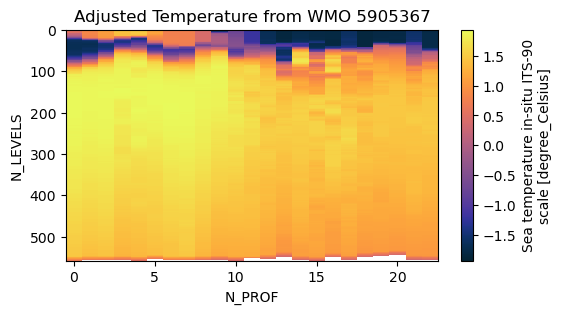

In [6]:
fig = flt_data.TEMP.T.plot(figsize = (6,3), cmap = cmo.thermal)
ax = plt.gca()
ax.invert_yaxis()
ax.set_title('Adjusted Temperature from WMO ' + str(wmo))

### Transforming an Xarray Dataset into a Pandas Dataframe.

- The pd Dataframe is a useful object resembling a table (can be interchangeable with .csv files). 
- After transforming to a Dataframe, we can easily pull variables of interest, and add others. 
- Note that having time in a numerical format (here, "yearday" since 2019-01-01) helps with training models. 

In [7]:
# Choose variables to use
float_df = flt_data[['JULD','LATITUDE', 'LONGITUDE','PRES_ADJUSTED','TEMP_ADJUSTED','PSAL_ADJUSTED',
                         'DOXY_ADJUSTED','NITRATE_ADJUSTED', # , 'PH_IN_SITU_TOTAL_ADJUSTED','BBP700_ADJUSTED', 
                        'JULD_QC', 'POSITION_QC', 'PRES_ADJUSTED_QC', 'TEMP_ADJUSTED_QC','PSAL_ADJUSTED_QC', 
                        'DOXY_ADJUSTED_QC', 'NITRATE_ADJUSTED_QC']].to_dataframe() #'BBP700_ADJUSTED_QC' #, 'PH_IN_SITU_TOTAL_ADJUSTED_QC',
dtimes = pd.to_datetime(float_df.JULD.values, unit='D', origin=pd.Timestamp('1950-01-01'))

def datetime2ytd(time):
    """ Return time in YTD format from datetime format.
    Sometimes easier to work with numerical date values."""
    return (time - np.datetime64('2019-01-01'))/np.timedelta64(1, 'D')
float_df['YEARDAY'] = datetime2ytd(dtimes)

# Make a profile ID for each profile
prof = float_df.index.get_level_values(0)
prof = prof.astype(str); prof = [tag.zfill(3) for tag in prof]
float_df['PROFID'] = [str(wmo)+tag for tag in prof]


# Convert QC flags to integers
qc_keys = ['JULD_QC', 'POSITION_QC', 'PRES_ADJUSTED_QC', 'TEMP_ADJUSTED_QC', 'PSAL_ADJUSTED_QC',
    'DOXY_ADJUSTED_QC', 'NITRATE_ADJUSTED_QC'] #, 'PH_IN_SITU_TOTAL_ADJUSTED_QC', 'BBP700_ADJUSTED_QC']
for key in qc_keys:  #qc flags are not stored as ints so we can convert
        newlist = []
        for qc in float_df[key]:
                if str(qc)[2] == 'n': newlist.append('NaN')
                else: newlist.append(str(qc)[2])
        float_df[key] = newlist


Here is what the resulting dataframe might look like: 

In [8]:
float_df

JULD  LATITUDE  LONGITUDE  PRES_ADJUSTED  \
N_PROF N_LEVELS                                                     
0      0         24833.537697   -63.024     69.947       2.730000   
       1         24833.537697   -63.024     69.947       4.330000   
       2         24833.537697   -63.024     69.947       6.330000   
       3         24833.537697   -63.024     69.947       7.340000   
       4         24833.537697   -63.024     69.947       8.330000   
...                       ...       ...        ...            ...   
22     554       25053.849977   -63.700     86.840    1699.869995   
       555       25053.849977   -63.700     86.840    1799.140015   
       556       25053.849977   -63.700     86.840    1898.789917   
       557       25053.849977   -63.700     86.840    1999.640015   
       558       25053.849977   -63.700     86.840            NaN   

                 TEMP_ADJUSTED  PSAL_ADJUSTED  DOXY_ADJUSTED  \
N_PROF N_LEVELS                                                
0      0              0.536000      33.638802            NaN   
       1              0.538000      33.638798            NaN   
       2              0.543000      33.637810            NaN   
       3              0.541485      33.637814     360.092163   
       4              0.540000      33.637814            NaN   
...                        ...            ...            ...   
22     554            0.500300      34.686153     206.296509   
       555            0.439100      34.683056     207.902771   
       556            0.380500      34.679558     209.396149   
       557            0.343800      34.676960     210.701538   
       558                 NaN            NaN            NaN   

                 NITRATE_ADJUSTED JULD_QC POSITION_QC PRES_ADJUSTED_QC  \
N_PROF N_LEVELS                                                          
0      0                      NaN       1           1                1   
       1                      NaN       1           1                1   
       2                      NaN       1           1                1   
       3                23.776834       1           1                1   
       4                      NaN       1           1                1   
...                           ...     ...         ...              ...   
22     554              32.713676       1           1                1   
       555              32.774677       1           1                1   
       556              32.887283       1           1                1   
       557              32.685017       1           1                1   
       558                    NaN       1           1              NaN   

                TEMP_ADJUSTED_QC PSAL_ADJUSTED_QC DOXY_ADJUSTED_QC  \
N_PROF N_LEVELS                                                      
0      0                       1                1              NaN   
       1                       1                1              NaN   
       2                       1                1              NaN   
       3                       8                8                1   
       4                       1                1              NaN   
...                          ...              ...              ...   
22     554                     1                1                1   
       555                     1                1                1   
       556                     1                1                1   
       557                     1                1                1   
       558                   NaN              NaN              NaN   

                NITRATE_ADJUSTED_QC     YEARDAY      PROFID  
N_PROF N_LEVELS                                              
0      0                        NaN -368.462303  5905367000  
       1                        NaN -368.462303  5905367000  
       2                        NaN -368.462303  5905367000  
       3                          1 -368.462303  5905367000  
       4                        NaN -368.462303 

### Considering dive-averaged data

The sampling strategy of the float is to sample as it ascends from a dive. 
If we want to know the average information for the entire dive, we can average over the dive observations.

In [9]:
def list_profile_DFs(df):
    """ 
    @param df: dataframe with all profiles
    @return: list of dataframes, each with a unique profile
    """
    PROFIDs = pd.unique(df.PROFID)
    profile_DFs = []
    for i in range(len(PROFIDs)):
        profile_DFs.append(df[df['PROFID']==PROFIDs[i]].copy())
    return profile_DFs


def make_diveav(df):
    """
    Make dive-averaged dataframes (per profile). 
    @param:    df: dataframe with all profiles
    @return:   single dataframe with dive-averaged data
    """
    prof_list = list_profile_DFs(df)

    newDF = pd.DataFrame()
    newDF['PROFID'] = pd.unique(df.PROFID)
    newDF['YEARDAY'] = [np.nanmean(x.YEARDAY) for x in prof_list]
    newDF['LATITUDE'] = [x.LATITUDE.mean() for x in prof_list]
    newDF['LONGITUDE'] = [x.LONGITUDE.mean() for x in prof_list]

    return newDF



- This particular float returns 23 profiles in the bounds we provided earlier.

In [10]:
float_dav = make_diveav(float_df)
float_dav

,PROFID,YEARDAY,LATITUDE,LONGITUDE
0,5905367000,-368.462303,-63.024000,69.947000
1,5905367001,-358.437384,-63.381000,70.567000
2,5905367002,-348.440185,-63.542000,72.828000
3,5905367003,-338.322535,-64.343000,74.709000
4,5905367004,-328.311134,-63.251000,76.556000
5,5905367005,-318.253692,-63.893000,79.424000
6,5905367006,-308.196863,-63.376000,79.971000
7,5905367007,-298.172708,-63.544000,78.989000
8,5905367008,-288.131956,-64.468000,78.684000
9,5905367009,-278.095498,-64.683000,79.777000


- Using the dive-averaged data, we can easily plot the overall trajectory using matplotlib.

Text(0.5, 1.0, 'Float 5905367 Trajectory in 2019')

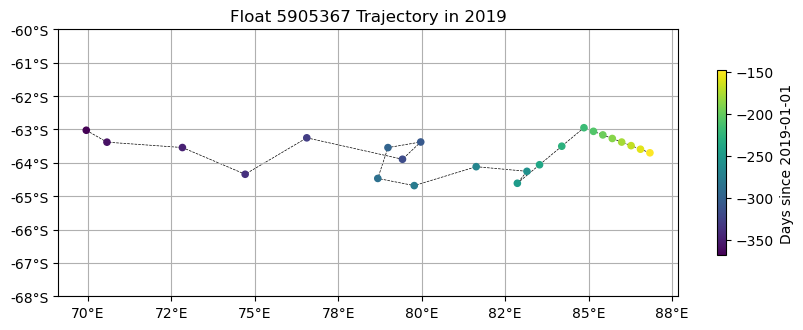

In [11]:
# plot with float trajectory

fig = plt.figure(figsize=(10,4))
ax = fig.gca()

sca = ax.scatter(float_dav.LONGITUDE, float_dav.LATITUDE, c=float_dav.YEARDAY, cmap='viridis', s=20, zorder=3)
ax.plot(float_dav.LONGITUDE, float_dav.LATITUDE, zorder=1, linewidth=0.5, linestyle='dashed', color='k')
plt.colorbar(sca, shrink=0.6, label='Days since 2019-01-01')

ax.yaxis.set_major_formatter("{x:1.0f}°S")
ax.xaxis.set_major_formatter("{x:1.0f}°E")
ax.set_aspect('equal')
ax.grid(zorder=1)
ax.set_ylim([-68, -60])

ax.set_title('Float ' + str(wmo) + ' Trajectory in 2019')

In the next notebook, [Accessing Argo](argo-access.ipynb), we go over more details on accessing the Argo data and plotting profiles. 

---

## Summary
Add one final `---` marking the end of your body of content, and then conclude with a brief single paragraph summarizing at a high level the key pieces that were learned and how they tied to your objectives. Look to reiterate what the most important takeaways were.

### What's next?
Let Jupyter book tie this to the next (sequential) piece of content that people could move on to down below and in the sidebar. However, if this page uniquely enables your reader to tackle other nonsequential concepts throughout this book, or even external content, link to it here!

## Resources and references
Finally, be rigorous in your citations and references as necessary. Give credit where credit is due. Also, feel free to link to relevant external material, further reading, documentation, etc. Then you're done! Give yourself a quick review, a high five, and send us a pull request. A few final notes:
 - `Kernel > Restart Kernel and Run All Cells...` to confirm that your notebook will cleanly run from start to finish
 - `Kernel > Restart Kernel and Clear All Outputs...` before committing your notebook, our machines will do the heavy lifting
 - Take credit! Provide author contact information if you'd like; if so, consider adding information here at the bottom of your notebook
 - Give credit! Attribute appropriate authorship for referenced code, information, images, etc.
 - Only include what you're legally allowed: **no copyright infringement or plagiarism**
 
Thank you for your contribution!